In [1]:
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import wandb
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from wandb.keras import WandbCallback

from modules.evaluate.utils import plot_tsne_pds
from modules.training.ts_modeling import build_dataset, create_mlp, evaluate_model, \
    process_sep_events, generate_feature_names


from scipy.stats import pearsonr

In [2]:
# SEEDING
SEED = 42  # seed number 

# Set NumPy seed
np.random.seed(SEED)

# Set TensorFlow seed
tf.random.set_seed(SEED)

# Set random seed
random.seed(SEED)


In [3]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
add_slope = False
target_change = False
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_dataset(root_dir + '/training',
                                 inputs_to_use=inputs_to_use,
                                 add_slope=add_slope,
                                 target_change=target_change)
X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining',
                                       inputs_to_use=inputs_to_use,
                                       add_slope=add_slope,
                                       target_change=target_change)
X_test, y_test = build_dataset(root_dir + '/testing',
                               inputs_to_use=inputs_to_use,
                               add_slope=add_slope,
                               target_change=target_change)
X_val, y_val = build_dataset(root_dir + '/validation',
                             inputs_to_use=inputs_to_use,
                             add_slope=add_slope,
                             target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

(24217, 75, 1)
(24217,)
(18952, 75, 1)
(18952,)
(10357, 75, 1)
(10357,)
(5265, 75, 1)
(5265,)
X_train.shape: (24217, 75, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 75, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 75, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 75, 1)
y_val.shape: (5265,)
X_train[0]: [[0.83291813]
 [0.83244193]
 [0.83128651]
 [0.83031191]
 [0.82795357]
 [0.82972685]
 [0.82913708]
 [0.82226368]
 [0.81980303]
 [0.81911433]
 [0.81761693]
 [0.81884725]
 [0.81879556]
 [0.81841966]
 [0.81626247]
 [0.81702354]
 [0.81599169]
 [0.81549917]
 [0.81538844]
 [0.81522678]
 [0.81357089]
 [0.81149916]
 [0.81334833]
 [0.81401486]
 [0.81195032]
 [0.48465527]
 [0.4788582 ]
 [0.4788582 ]
 [0.47614084]
 [0.47311252]
 [0.47398247]
 [0.47180709]
 [0.45771414]
 [0.44302786]
 [0.44819982]
 [0.45129612]
 [0.4395381 ]
 [0.45298753]
 [0.44381562]
 [0.44287087]
 [0.44223638]
 [0.44144699]
 [0.44001532]
 [0.43358671]
 [0.43114536]
 [0.44413254]
 [0.43163419]
 [0.43260982]
 [0.4361

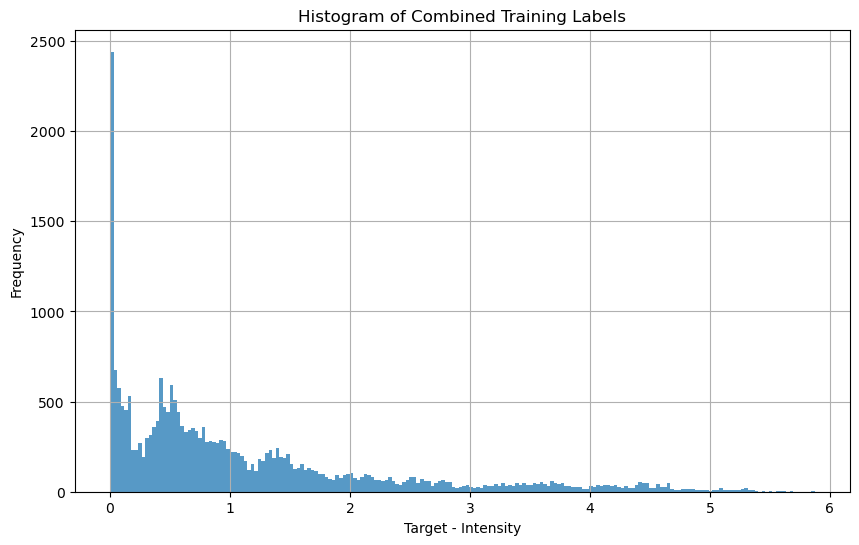

In [30]:
# Assuming y_train and y_test are your training and testing label arrays
# Combine the training and testing labels
# combined_labels = np.concatenate([y_train, y_test])

# Plot the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(y_train, bins=200, alpha=0.75)  # Adjust 'bins' as needed
plt.title('Histogram of Combined Training Labels')
plt.xlabel('Target - Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

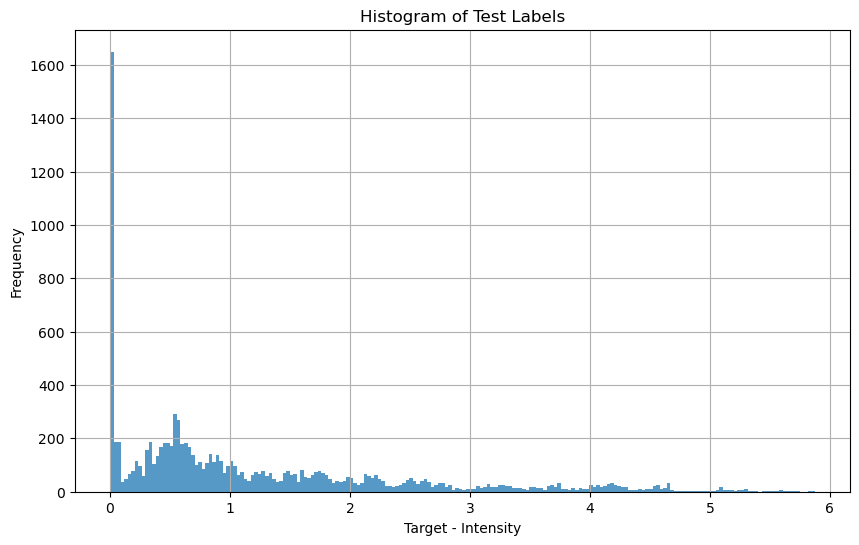

In [33]:
# Assuming y_train and y_test are your training and testing label arrays
# Combine the training and testing labels
# combined_labels = np.concatenate([y_train, y_test])

# Plot the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(y_test, bins=200, alpha=0.75)  # Adjust 'bins' as needed
plt.title('Histogram of Test Labels')
plt.xlabel('Target - Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [4]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
add_slope = True
outputs_to_use = ['delta_p']
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_dataset(root_dir + '/training',
                                 inputs_to_use=inputs_to_use,
                                 add_slope=add_slope,
                                 outputs_to_use=outputs_to_use)
X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining',
                                       inputs_to_use=inputs_to_use,
                                       add_slope=add_slope,
                                       outputs_to_use=outputs_to_use)
X_test, y_test = build_dataset(root_dir + '/testing',
                               inputs_to_use=inputs_to_use,
                               add_slope=add_slope,
                               outputs_to_use=outputs_to_use)
X_val, y_val = build_dataset(root_dir + '/validation',
                             inputs_to_use=inputs_to_use,
                             add_slope=add_slope,
                             outputs_to_use=outputs_to_use)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

X_train.shape: (24217, 147, 1)
y_train.shape: (24217, 1)
X_subtrain.shape: (18952, 147, 1)
y_subtrain.shape: (18952, 1)
X_test.shape: (10357, 147, 1)
y_test.shape: (10357, 1)
X_val.shape: (5265, 147, 1)
y_val.shape: (5265, 1)
X_train[0]: [[ 8.32918127e-01]
 [ 8.32441929e-01]
 [ 8.31286513e-01]
 [ 8.30311912e-01]
 [ 8.27953573e-01]
 [ 8.29726848e-01]
 [ 8.29137084e-01]
 [ 8.22263682e-01]
 [ 8.19803034e-01]
 [ 8.19114328e-01]
 [ 8.17616930e-01]
 [ 8.18847247e-01]
 [ 8.18795562e-01]
 [ 8.18419663e-01]
 [ 8.16262466e-01]
 [ 8.17023541e-01]
 [ 8.15991693e-01]
 [ 8.15499170e-01]
 [ 8.15388439e-01]
 [ 8.15226785e-01]
 [ 8.13570890e-01]
 [ 8.11499156e-01]
 [ 8.13348330e-01]
 [ 8.14014860e-01]
 [ 8.11950317e-01]
 [ 4.84655267e-01]
 [ 4.78858197e-01]
 [ 4.78858197e-01]
 [ 4.76140841e-01]
 [ 4.73112523e-01]
 [ 4.73982469e-01]
 [ 4.71807092e-01]
 [ 4.57714143e-01]
 [ 4.43027860e-01]
 [ 4.48199824e-01]
 [ 4.51296118e-01]
 [ 4.39538095e-01]
 [ 4.52987532e-01]
 [ 4.43815616e-01]
 [ 4.42870870e-01]
 [

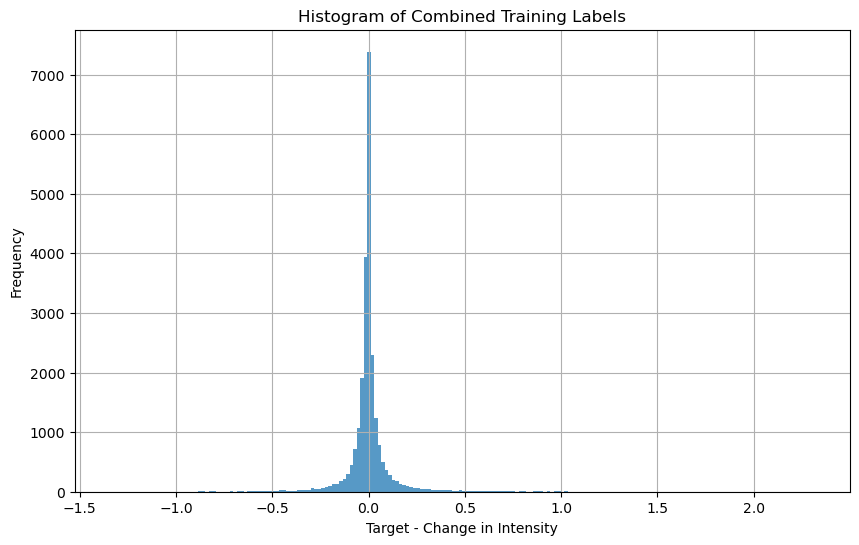

In [5]:
# Assuming y_train and y_test are your training and testing label arrays
# Combine the training and testing labels
# combined_labels = np.concatenate([y_train, y_test])

# Plot the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(y_train, bins=200, alpha=0.75)  # Adjust 'bins' as needed
plt.title('Histogram of Combined Training Labels')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

y_train[0]: -0.00509054986278612


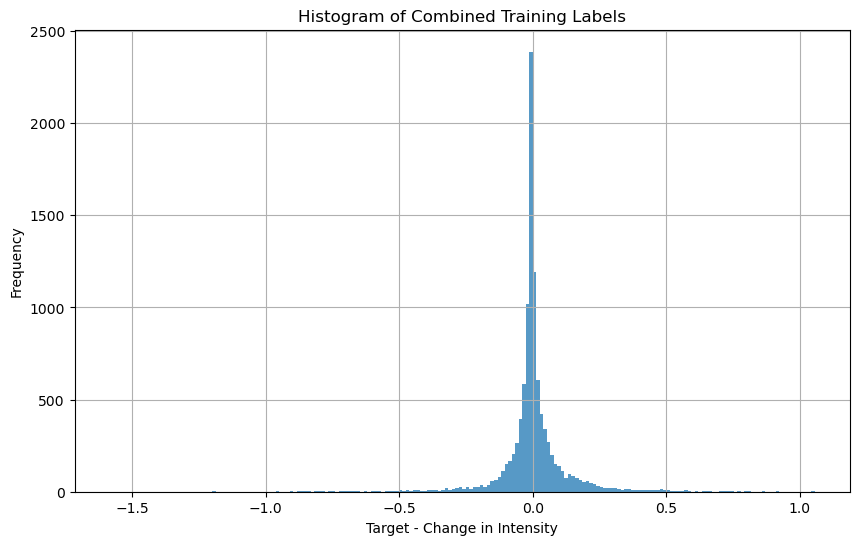

In [39]:
print(f'y_train[0]: {y_test[0]}')
# Assuming y_train and y_test are your training and testing label arrays
# Combine the training and testing labels
# combined_labels = np.concatenate([y_train, y_test])

# Plot the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(y_test, bins=200, alpha=0.75)  # Adjust 'bins' as needed
plt.title('Histogram of Combined Training Labels')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [36]:
# Find min and max y values
min_y_value = np.min(y_train)
max_y_value = np.max(y_train)
# Calculate frequencies of min and max y values
min_y_freq = np.count_nonzero(y_train == min_y_value)
max_y_freq = np.count_nonzero(y_train == max_y_value)
print(f'Min Y: {min_y_value}, Frequency: {min_y_freq}')
print(f'Max Y: {max_y_value}, Frequency: {max_y_freq}')

Min Y: -1.3432244844152144, Frequency: 1
Max Y: 2.3157651077870685, Frequency: 1


In [37]:
# Find min and max y values
min_y_value = np.min(y_test)
max_y_value = np.max(y_test)
# Calculate frequencies of min and max y values
min_y_freq = np.count_nonzero(y_test == min_y_value)
max_y_freq = np.count_nonzero(y_test == max_y_value)
print(f'Min Y: {min_y_value}, Frequency: {min_y_freq}')
print(f'Max Y: {max_y_value}, Frequency: {max_y_freq}')

Min Y: -1.5838650212232528, Frequency: 1
Max Y: 1.0561572515516193, Frequency: 1


In [9]:
from scipy.stats import gaussian_kde, mode
bw = 0.0519

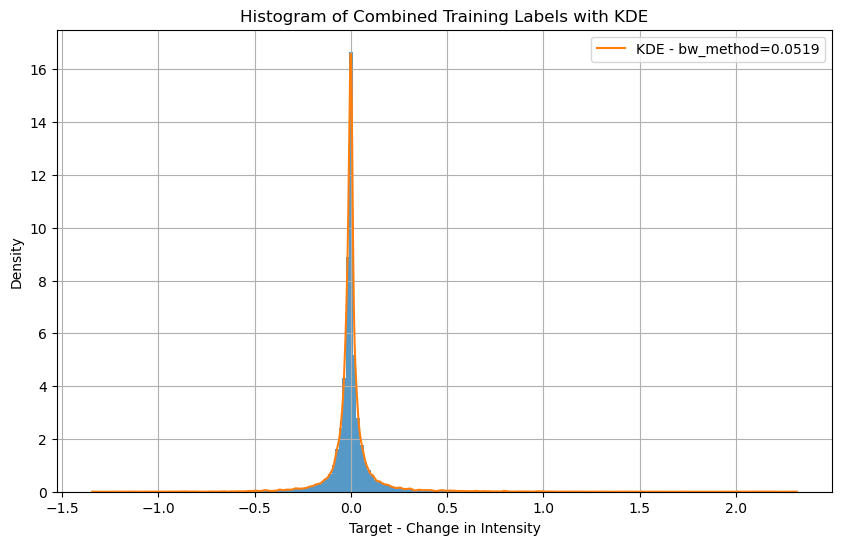

In [22]:
# Create a KDE object using the Scott method for bandwidth selection
kde = gaussian_kde(y_train, bw_method=bw)

# Create a range of values for which we want the KDE evaluated
x_eval = np.linspace(np.min(y_train), np.max(y_train), 1000)  # Adjust range and number of points as needed

# Evaluate the KDE for each x value
density = kde.evaluate(x_eval)

# Plot the original histogram
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=200, alpha=0.75, density=True)  # 'density=True' to normalize the histogram
plt.plot(x_eval, density, label='KDE - bw_method=0.0519')
plt.title('Histogram of Combined Training Labels with KDE')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
# Step 1: Compute the KDE
data = y_train  # Your dataset
kde = gaussian_kde(data, bw_method=bw)
# Step 2: Find the most frequent value
# Approach 1: Using the mode (most frequent value in the dataset)
mode_value = mode(data, keepdims=True)[0][0]  # 'mode' returns mode and count; we take the first mode in case of multiple modes

# Approach 2: Find the peak of the KDE (for a more continuous approximation of "most frequent")
x_eval = np.linspace(np.min(data), np.max(data), 1000)  # Range of values to evaluate
densities = kde.evaluate(x_eval)  # Evaluate the KDE
peak_index = np.argmax(densities)  # Index of the peak density
most_frequent_value = x_eval[peak_index]  # The value corresponding to the peak density

# Step 3: Evaluate the KDE at min, max, and most frequent value
min_density = kde.evaluate([np.min(data)])[0]
max_density = kde.evaluate([np.max(data)])[0]
most_frequent_density = kde.evaluate([most_frequent_value])[0]

# Step 4: Calculate the density ratios
ratio_max_to_most_frequent = max_density / most_frequent_density
ratio_min_to_most_frequent = min_density / most_frequent_density

print("Density ratio (max to most frequent):", ratio_max_to_most_frequent)
print("Density ratio (min to most frequent):", ratio_min_to_most_frequent)

Density ratio (max to most frequent): 0.0001385674134483799
Density ratio (min to most frequent): 0.00019980709724612777


In [6]:
from modules.training.DenseReweights import DenseReweights

C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\pydantic\_internal\_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\pydantic\_internal\_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [40]:
min_norm_weight = 0.01 / len(y_train)
combined_sample_weights = DenseReweights(
    X_train, y_train, alpha=10, bw=bw, min_norm_weight=min_norm_weight, debug=False).reweights

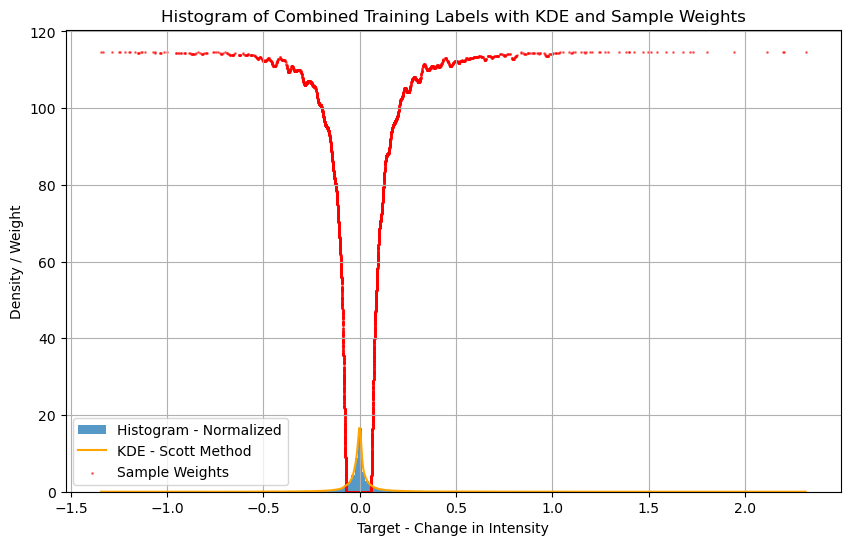

In [41]:
# Assuming 'y_train' is your dataset and 'combined_sample_weights' are the weights you mentioned

# Create a KDE object using the Scott method for bandwidth selection
kde = gaussian_kde(y_train, bw_method=bw)

# Create a range of values for which we want the KDE evaluated
x_eval = np.linspace(np.min(y_train), np.max(y_train), 1000)  # Adjust range and number of points as needed

# Evaluate the KDE for each x value
density = kde.evaluate(x_eval)

# Plot the original histogram and KDE
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=200, alpha=0.75, density=True, label='Histogram - Normalized')  # 'density=True' to normalize the histogram
plt.plot(x_eval, density, label='KDE - Scott Method', color='orange')

# Since 'combined_sample_weights' and 'y_train' should align, we plot the weights against the y_train values
# It's important to normalize or scale the weights if they're on a very different scale from your KDE/density values
# This step might require adjusting the 's' parameter (size) based on your data scale
plt.scatter(y_train, combined_sample_weights * np.max(density), label='Sample Weights', color='red', s=1, alpha=0.5)

plt.title('Histogram of Combined Training Labels with KDE and Sample Weights')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Density / Weight')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
from modules.training.DenseReweights import exDenseReweights
bw = 0.0519

In [13]:
# Compute the sample weights
delta_train = y_train[:, 0]
min_norm_weight = 0.01 / len(delta_train)
combined_sample_weights = exDenseReweights(
    X_train, delta_train, alpha=1, bw=bw, min_norm_weight=min_norm_weight, debug=False).reweights

In [15]:
# Find min and max y values
min_y_value = np.min(delta_train)
max_y_value = np.max(delta_train)
# find index of min and max values 
min_y_index = np.argmin(delta_train)
print(f'weight of minimum {min_y_value}: {combined_sample_weights[min_y_index]}')
max_y_index = np.argmax(delta_train)
print(f'weight of maximum {max_y_value}: {combined_sample_weights[max_y_index]}')

weight of minimum -1.3432244844152144: 0.4317628127616164
weight of maximum 2.3157651077870685: 2606.2635996137737


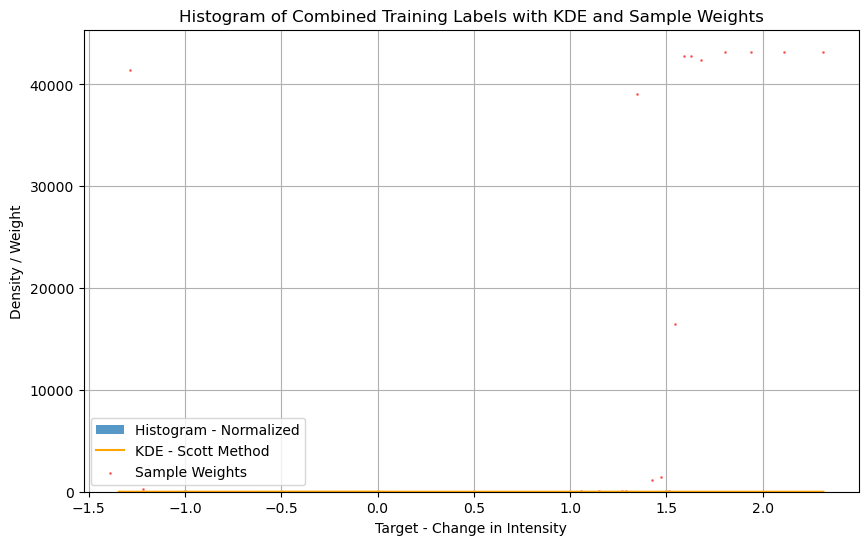

In [9]:
# Assuming 'y_train' is your dataset and 'combined_sample_weights' are the weights you mentioned

# Create a KDE object using the Scott method for bandwidth selection
kde = gaussian_kde(y_train, bw_method=bw)

# Create a range of values for which we want the KDE evaluated
x_eval = np.linspace(np.min(y_train), np.max(y_train), 1000)  # Adjust range and number of points as needed

# Evaluate the KDE for each x value
density = kde.evaluate(x_eval)

# Plot the original histogram and KDE
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=200, alpha=0.75, density=True, label='Histogram - Normalized')  # 'density=True' to normalize the histogram
plt.plot(x_eval, density, label='KDE - Scott Method', color='orange')

# Since 'combined_sample_weights' and 'y_train' should align, we plot the weights against the y_train values
# It's important to normalize or scale the weights if they're on a very different scale from your KDE/density values
# This step might require adjusting the 's' parameter (size) based on your data scale
plt.scatter(y_train, combined_sample_weights * np.max(density), label='Sample Weights', color='red', s=1, alpha=0.5)

plt.title('Histogram of Combined Training Labels with KDE and Sample Weights')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Density / Weight')
plt.grid(True)
plt.legend()
plt.show()

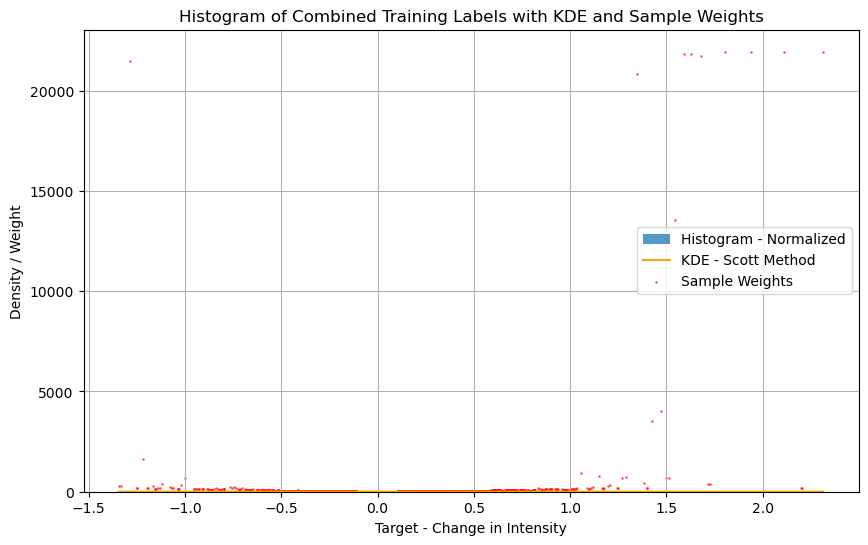

In [10]:
min_norm_weight = 0.01 / len(y_train)
combined_sample_weights = exDenseReweights(
    X_train, y_train, alpha=0.5, bw=bw, min_norm_weight=min_norm_weight, debug=False).reweights

# Assuming 'y_train' is your dataset and 'combined_sample_weights' are the weights you mentioned

# Create a KDE object using the Scott method for bandwidth selection
kde = gaussian_kde(y_train, bw_method=bw)

# Create a range of values for which we want the KDE evaluated
x_eval = np.linspace(np.min(y_train), np.max(y_train), 1000)  # Adjust range and number of points as needed

# Evaluate the KDE for each x value
density = kde.evaluate(x_eval)

# Plot the original histogram and KDE
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=200, alpha=0.75, density=True, label='Histogram - Normalized')  # 'density=True' to normalize the histogram
plt.plot(x_eval, density, label='KDE - Scott Method', color='orange')

# Since 'combined_sample_weights' and 'y_train' should align, we plot the weights against the y_train values
# It's important to normalize or scale the weights if they're on a very different scale from your KDE/density values
# This step might require adjusting the 's' parameter (size) based on your data scale
plt.scatter(y_train, combined_sample_weights * np.max(density), label='Sample Weights', color='red', s=1, alpha=0.5)

plt.title('Histogram of Combined Training Labels with KDE and Sample Weights')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Density / Weight')
plt.grid(True)
plt.legend()
plt.show()

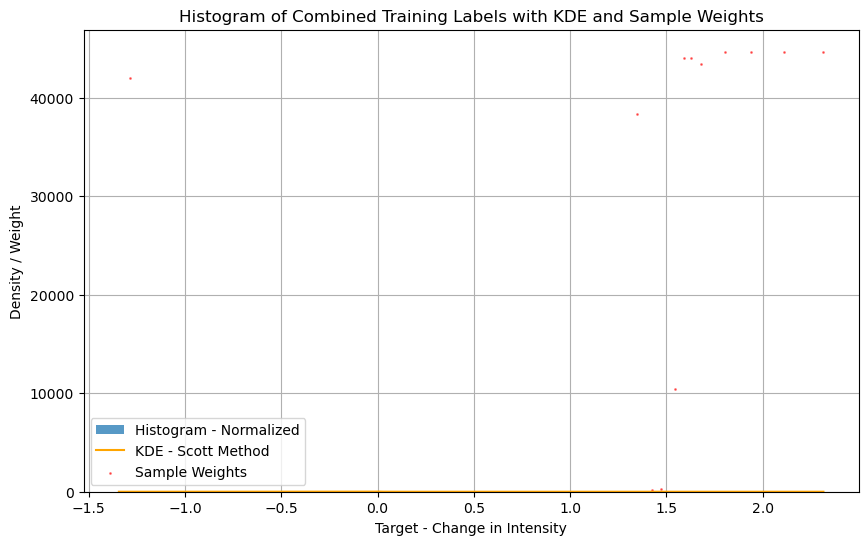

In [11]:
min_norm_weight = 0.01 / len(y_train)
combined_sample_weights = exDenseReweights(
    X_train, y_train, alpha=1.5, bw=bw, min_norm_weight=min_norm_weight, debug=False).reweights

# Assuming 'y_train' is your dataset and 'combined_sample_weights' are the weights you mentioned

# Create a KDE object using the Scott method for bandwidth selection
kde = gaussian_kde(y_train, bw_method=bw)

# Create a range of values for which we want the KDE evaluated
x_eval = np.linspace(np.min(y_train), np.max(y_train), 1000)  # Adjust range and number of points as needed

# Evaluate the KDE for each x value
density = kde.evaluate(x_eval)

# Plot the original histogram and KDE
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=200, alpha=0.75, density=True, label='Histogram - Normalized')  # 'density=True' to normalize the histogram
plt.plot(x_eval, density, label='KDE - Scott Method', color='orange')

# Since 'combined_sample_weights' and 'y_train' should align, we plot the weights against the y_train values
# It's important to normalize or scale the weights if they're on a very different scale from your KDE/density values
# This step might require adjusting the 's' parameter (size) based on your data scale
plt.scatter(y_train, combined_sample_weights * np.max(density), label='Sample Weights', color='red', s=1, alpha=0.5)

plt.title('Histogram of Combined Training Labels with KDE and Sample Weights')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Density / Weight')
plt.grid(True)
plt.legend()
plt.show()

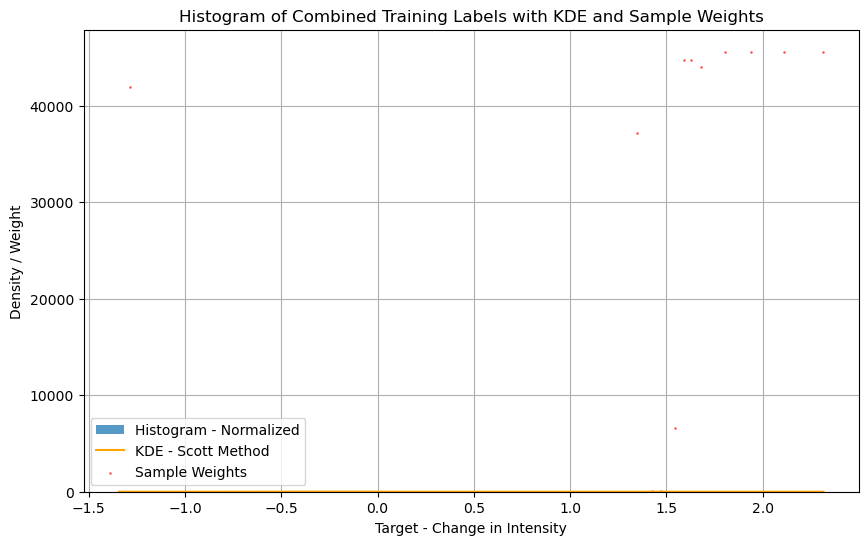

In [12]:
min_norm_weight = 0.01 / len(y_train)
combined_sample_weights = exDenseReweights(
    X_train, y_train, alpha=2, bw=bw, min_norm_weight=min_norm_weight, debug=False).reweights

# Assuming 'y_train' is your dataset and 'combined_sample_weights' are the weights you mentioned

# Create a KDE object using the Scott method for bandwidth selection
kde = gaussian_kde(y_train, bw_method=bw)

# Create a range of values for which we want the KDE evaluated
x_eval = np.linspace(np.min(y_train), np.max(y_train), 1000)  # Adjust range and number of points as needed

# Evaluate the KDE for each x value
density = kde.evaluate(x_eval)

# Plot the original histogram and KDE
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=200, alpha=0.75, density=True, label='Histogram - Normalized')  # 'density=True' to normalize the histogram
plt.plot(x_eval, density, label='KDE - Scott Method', color='orange')

# Since 'combined_sample_weights' and 'y_train' should align, we plot the weights against the y_train values
# It's important to normalize or scale the weights if they're on a very different scale from your KDE/density values
# This step might require adjusting the 's' parameter (size) based on your data scale
plt.scatter(y_train, combined_sample_weights * np.max(density), label='Sample Weights', color='red', s=1, alpha=0.5)

plt.title('Histogram of Combined Training Labels with KDE and Sample Weights')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Density / Weight')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
from modules.training.DenseReweights import DenseJointReweights

In [ ]:
min_norm_weight = 0.01 / len(y_train)

train_jweights = DenseJointReweights(X_train, y_train, 
                                     alpha=.9, bw='scott', 
                                     min_norm_weight=min_norm_weight, 
                                     debug=True)

In [ ]:
# Assuming train_jweights contains the combined joint reweighting info
train_sample_joint_weights = train_jweights.jreweights
train_sample_joint_weights_indices = train_jweights.jindices


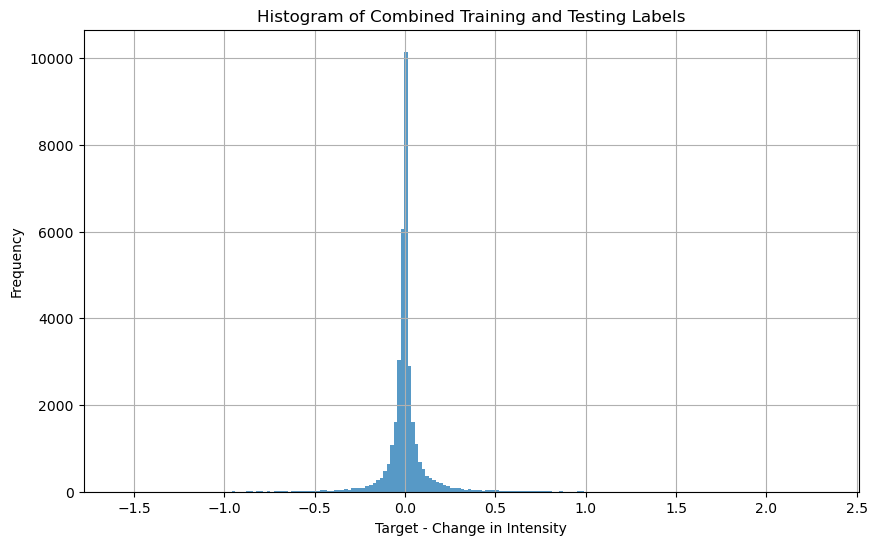

In [17]:
# Assuming y_train and y_test are your training and testing label arrays
# Combine the training and testing labels
combined_labels = np.concatenate([y_train, y_test])

# Plot the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(combined_labels, bins=200, alpha=0.75)  # Adjust 'bins' as needed
plt.title('Histogram of Combined Training and Testing Labels')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [7]:
# Find min and max y values
min_y_value = np.min(combined_labels)
max_y_value = np.max(combined_labels)
# Calculate frequencies of min and max y values
min_y_freq = np.count_nonzero(combined_labels == min_y_value)
max_y_freq = np.count_nonzero(combined_labels == max_y_value)
print(f'Min Y: {min_y_value}, Frequency: {min_y_freq}')
print(f'Max Y: {max_y_value}, Frequency: {max_y_freq}')

Min Y: -1.5838650212232528, Frequency: 1
Max Y: 2.3157651077870685, Frequency: 1


Highest frequency bin center: 0.005234256348452981, Frequency: 10150.0


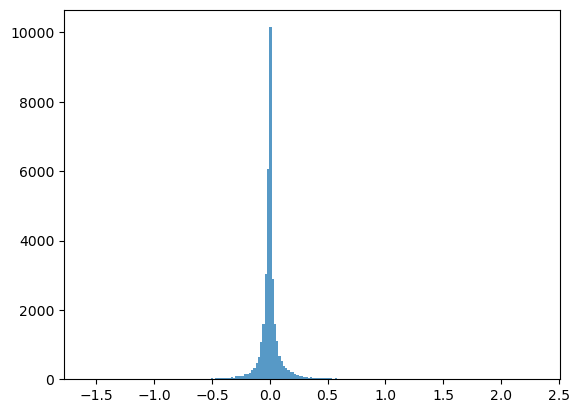

In [8]:
# Plot the histogram and get bin counts and edges
counts, bins, patches = plt.hist(combined_labels, bins=200, alpha=0.75)

# Find the bin with the highest frequency
highest_freq_index = np.argmax(counts)
highest_freq_bin_center = (bins[highest_freq_index] + bins[highest_freq_index + 1]) / 2
highest_freq = counts[highest_freq_index]
print(f'Highest frequency bin center: {highest_freq_bin_center}, Frequency: {highest_freq}')

D:\College\Fall2023\sep-forecasting-research\modules\training\ts_modeling.py:2297: RuntimeWarning: invalid value encountered in log
  return np.where(x > 0, np.log(x + 1), np.log(np.abs(x) + 1) * np.sign(x))


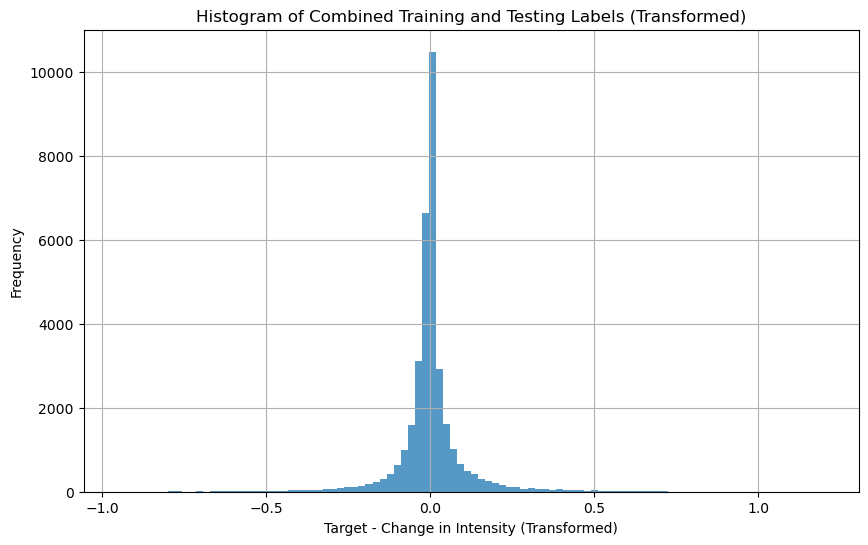

In [9]:
# Apply the desired function to the labels
transformed_labels = sym_log1p(combined_labels)  # Replace np.exp with your desired function

# Plot the histogram with transformed labels
plt.figure(figsize=(10, 6))
plt.hist(transformed_labels, bins=100, alpha=0.75)
plt.title('Histogram of Combined Training and Testing Labels (Transformed)')
plt.xlabel('Target - Change in Intensity (Transformed)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
# def apply_function(x, function):
#     """ Applies a function to each element of a NumPy array.
#   
#     Args:
#       x: A NumPy array.
#       function: A function that takes a single element of the array as input and returns the transformed value.
#   
#     Returns:
#       A new NumPy array with the transformed values.
#     """
#     return np.frompyfunc(lambda a: function(a), 1, 1)(x)
# 
# 
# # Apply the desired function to the labels
# transformed_labels = apply_function(combined_labels, np.log1p)  # Replace np.exp with your desired function
# 
# # Plot the histogram with transformed labels
# plt.figure(figsize=(10, 6))
# plt.hist(transformed_labels, bins=200, alpha=0.75)
# plt.title('Histogram of Combined Training and Testing Labels (Transformed)')
# plt.xlabel('Target - Change in Intensity (Transformed)')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()


In [ ]:
# # Annotate min, max, and highest frequency y value
# plt.annotate(f'Min Y: {min_y_value:.2f}', xy=(min_y_value, 0), xytext=(min_y_value, 10),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate(f'Max Y: {max_y_value:.2f}', xy=(max_y_value, 0), xytext=(max_y_value, 10),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate(f'Highest Freq Y: {highest_freq_bin_center:.2f}\nFreq: {highest_freq}',
#              xy=(highest_freq_bin_center, highest_freq),
#              xytext=(highest_freq_bin_center, highest_freq + 0.05 * np.ptp(counts)),
#              arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center')
# 
# plt.show()

In [ ]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
input_to_return = 'p_t'
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_univariate_dataset(root_dir + '/training',
                                            inputs_to_use=inputs_to_use,
                                            input_to_return=input_to_return,
                                            add_slope=add_slope,
                                            target_change=target_change)
X_subtrain, y_subtrain = build_univariate_dataset(root_dir + '/subtraining',
                                                  inputs_to_use=inputs_to_use,
                                                  input_to_return=input_to_return,
                                                  add_slope=add_slope,
                                                  target_change=target_change)
X_test, y_test = build_univariate_dataset(root_dir + '/testing',
                                          inputs_to_use=inputs_to_use,
                                          input_to_return=input_to_return,
                                          add_slope=add_slope,
                                          target_change=target_change)
X_val, y_val = build_univariate_dataset(root_dir + '/validation',
                                        inputs_to_use=inputs_to_use,
                                        input_to_return=input_to_return,
                                        add_slope=add_slope,
                                        target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

In [ ]:
# Since X_train, and other datasets, are in the shape (n_samples, 1), we need to flatten them to (n_samples,)
X_train_flat = X_train.flatten()

# Plotting the target vs input feature 'p_t'
plt.figure(figsize=(10, 6))
plt.scatter(X_train_flat, y_train, alpha=0.5, label='Training data', s=1)
plt.title('Target vs. Input Feature (p_t)')
plt.xlabel('Input Feature (p_t)')
plt.ylabel('Target')
plt.legend()
plt.show()

In [2]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
input_to_return = 'e0.5_t'
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_univariate_dataset(root_dir + '/training',
                                            inputs_to_use=inputs_to_use,
                                            input_to_return=input_to_return,
                                            add_slope=add_slope,
                                            target_change=target_change)
X_subtrain, y_subtrain = build_univariate_dataset(root_dir + '/subtraining',
                                                  inputs_to_use=inputs_to_use,
                                                  input_to_return=input_to_return,
                                                  add_slope=add_slope,
                                                  target_change=target_change)
X_test, y_test = build_univariate_dataset(root_dir + '/testing',
                                          inputs_to_use=inputs_to_use,
                                          input_to_return=input_to_return,
                                          add_slope=add_slope,
                                          target_change=target_change)
X_val, y_val = build_univariate_dataset(root_dir + '/validation',
                                        inputs_to_use=inputs_to_use,
                                        input_to_return=input_to_return,
                                        add_slope=add_slope,
                                        target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

# Since X_train, and other datasets, are in the shape (n_samples, 1), we need to flatten them to (n_samples,)
X_train_flat = X_train.flatten()

# Plotting the target vs input feature 'p_t'
plt.figure(figsize=(10, 6))
plt.scatter(X_train_flat, y_train, alpha=0.5, label='Training data', s=1, color='orange')
plt.title('Target vs. Input Feature (e0.5_t)')
plt.xlabel('Input Feature (e0.5_t)')
plt.ylabel('Target')
plt.legend()
plt.show()

NameError: name 'build_univariate_dataset' is not defined

X_train.shape: (24217, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 1)
y_val.shape: (5265,)
X_train[0]: [0.42521301]
y_train[0]: 0.7607123667223692


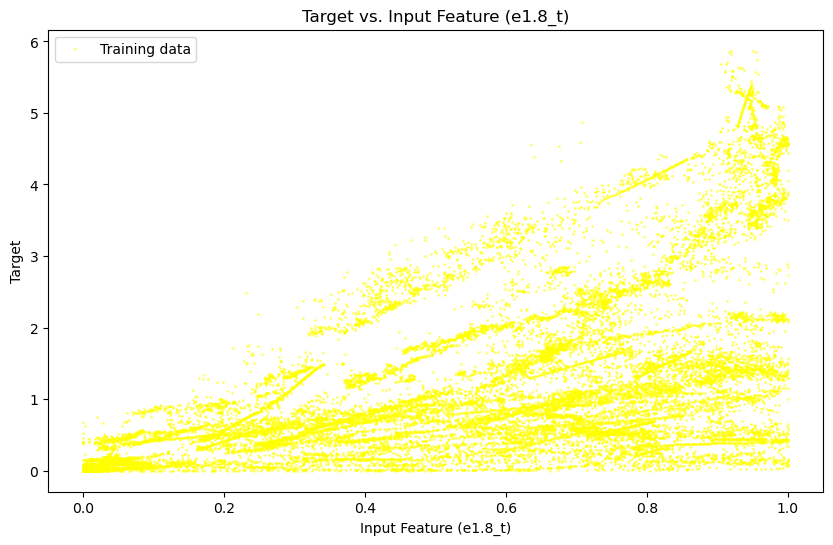

In [13]:
inputs_to_use = ['e1.8', 'e1.8', 'p']
input_to_return = 'e1.8_t'
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_univariate_dataset(root_dir + '/training',
                                            inputs_to_use=inputs_to_use,
                                            input_to_return=input_to_return,
                                            add_slope=add_slope,
                                            target_change=target_change)
X_subtrain, y_subtrain = build_univariate_dataset(root_dir + '/subtraining',
                                                  inputs_to_use=inputs_to_use,
                                                  input_to_return=input_to_return,
                                                  add_slope=add_slope,
                                                  target_change=target_change)
X_test, y_test = build_univariate_dataset(root_dir + '/testing',
                                          inputs_to_use=inputs_to_use,
                                          input_to_return=input_to_return,
                                          add_slope=add_slope,
                                          target_change=target_change)
X_val, y_val = build_univariate_dataset(root_dir + '/validation',
                                        inputs_to_use=inputs_to_use,
                                        input_to_return=input_to_return,
                                        add_slope=add_slope,
                                        target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

# Since X_train, and other datasets, are in the shape (n_samples, 1), we need to flatten them to (n_samples,)
X_train_flat = X_train.flatten()

# Plotting the target vs input feature 'p_t'
plt.figure(figsize=(10, 6))
plt.scatter(X_train_flat, y_train, alpha=0.5, label='Training data', s=1, color='yellow')
plt.title('Target vs. Input Feature (e1.8_t)')
plt.xlabel('Input Feature (e1.8_t)')
plt.ylabel('Target')
plt.legend()
plt.show()

In [14]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_dataset(root_dir + '/training',
                                 inputs_to_use=inputs_to_use,
                                 add_slope=add_slope,
                                 target_change=target_change)
X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining',
                                       inputs_to_use=inputs_to_use,
                                       add_slope=add_slope,
                                       target_change=target_change)
X_test, y_test = build_dataset(root_dir + '/testing',
                               inputs_to_use=inputs_to_use,
                               add_slope=add_slope,
                               target_change=target_change)
X_val, y_val = build_dataset(root_dir + '/validation',
                             inputs_to_use=inputs_to_use,
                             add_slope=add_slope,
                             target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

(24217, 75, 1)
(24217,)
(18952, 75, 1)
(18952,)
(10357, 75, 1)
(10357,)
(5265, 75, 1)
(5265,)
X_train.shape: (24217, 75, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 75, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 75, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 75, 1)
y_val.shape: (5265,)
X_train[0]: [[0.83291813]
 [0.83244193]
 [0.83128651]
 [0.83031191]
 [0.82795357]
 [0.82972685]
 [0.82913708]
 [0.82226368]
 [0.81980303]
 [0.81911433]
 [0.81761693]
 [0.81884725]
 [0.81879556]
 [0.81841966]
 [0.81626247]
 [0.81702354]
 [0.81599169]
 [0.81549917]
 [0.81538844]
 [0.81522678]
 [0.81357089]
 [0.81149916]
 [0.81334833]
 [0.81401486]
 [0.81195032]
 [0.48465527]
 [0.4788582 ]
 [0.4788582 ]
 [0.47614084]
 [0.47311252]
 [0.47398247]
 [0.47180709]
 [0.45771414]
 [0.44302786]
 [0.44819982]
 [0.45129612]
 [0.4395381 ]
 [0.45298753]
 [0.44381562]
 [0.44287087]
 [0.44223638]
 [0.44144699]
 [0.44001532]
 [0.43358671]
 [0.43114536]
 [0.44413254]
 [0.43163419]
 [0.43260982]
 [0.4361

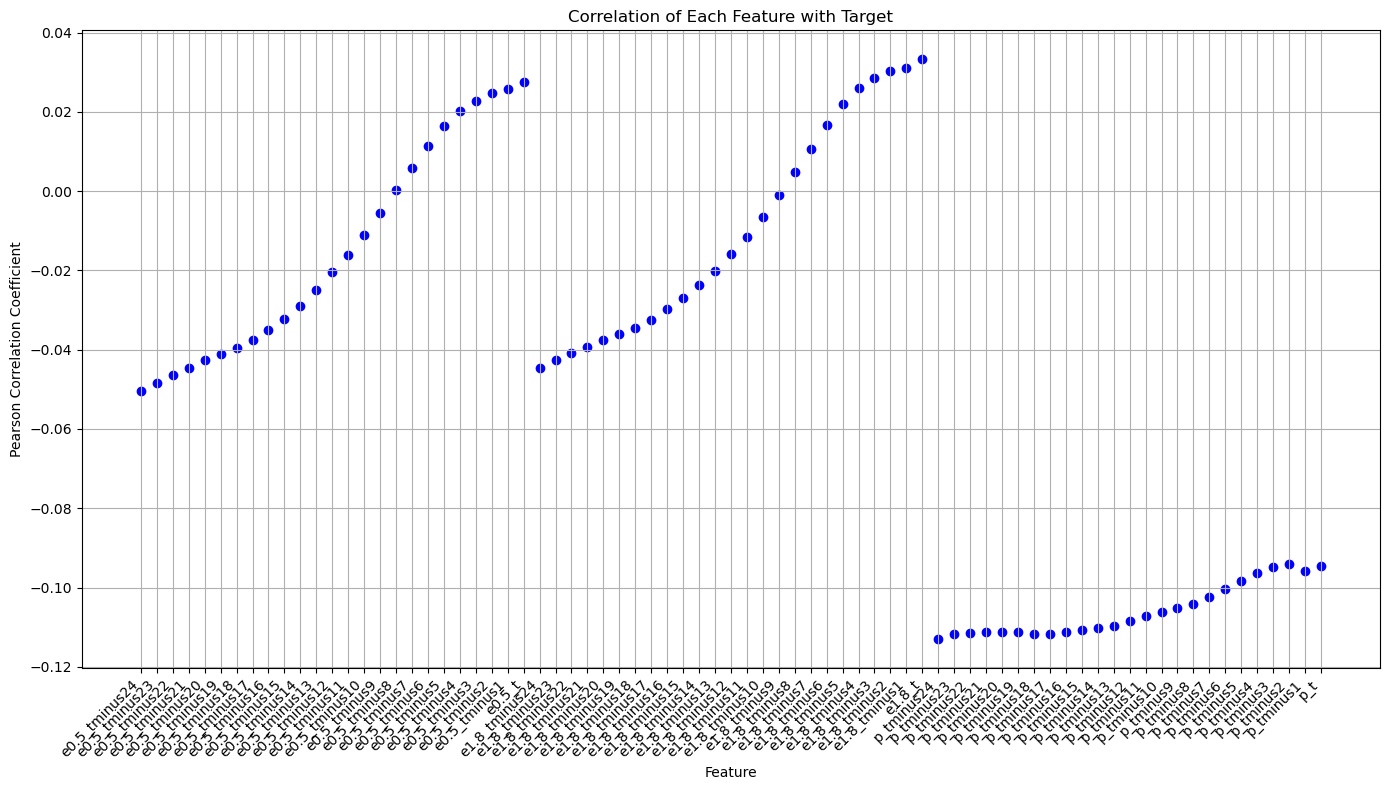

In [18]:
# Assuming X_train is shaped (24217, 75, 1) and y_train is (24217,)
# Reshape X_train to (24217, 75) for easier processing
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1])

# Initialize a list to hold correlation coefficients
correlations = []

# Calculate the Pearson correlation coefficient for each feature
for i in range(X_train_reshaped.shape[1]):
    corr, _ = pearsonr(X_train_reshaped[:, i], y_train)
    correlations.append(corr)
    
feature_names = generate_feature_names(inputs_to_use, add_slope)

# Plotting as a scatter plot
plt.figure(figsize=(14, 8))  # Adjusted figure size for better legibility
plt.scatter(range(len(correlations)), correlations, color='b')  # Use scatter instead of plot

# Adding feature names on the x-axis
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")  # Rotate labels to prevent overlap

plt.title('Correlation of Each Feature with Target')
plt.xlabel('Feature')
plt.ylabel('Pearson Correlation Coefficient')
plt.grid(True)

# Tight layout often solves cutting off issues
plt.tight_layout()
plt.show()

In [4]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
add_slope = True
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_dataset(root_dir + '/training',
                                 inputs_to_use=inputs_to_use,
                                 add_slope=add_slope,
                                 target_change=target_change)
X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining',
                                       inputs_to_use=inputs_to_use,
                                       add_slope=add_slope,
                                       target_change=target_change)
X_test, y_test = build_dataset(root_dir + '/testing',
                               inputs_to_use=inputs_to_use,
                               add_slope=add_slope,
                               target_change=target_change)
X_val, y_val = build_dataset(root_dir + '/validation',
                             inputs_to_use=inputs_to_use,
                             add_slope=add_slope,
                             target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
# print(f'X_train[0]: {X_train[0]}')
# print(f'y_train[0]: {y_train[0]}')

(24217, 147, 1)
(24217,)
(18952, 147, 1)
(18952,)
(10357, 147, 1)
(10357,)
(5265, 147, 1)
(5265,)
X_train.shape: (24217, 147, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 147, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 147, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 147, 1)
y_val.shape: (5265,)


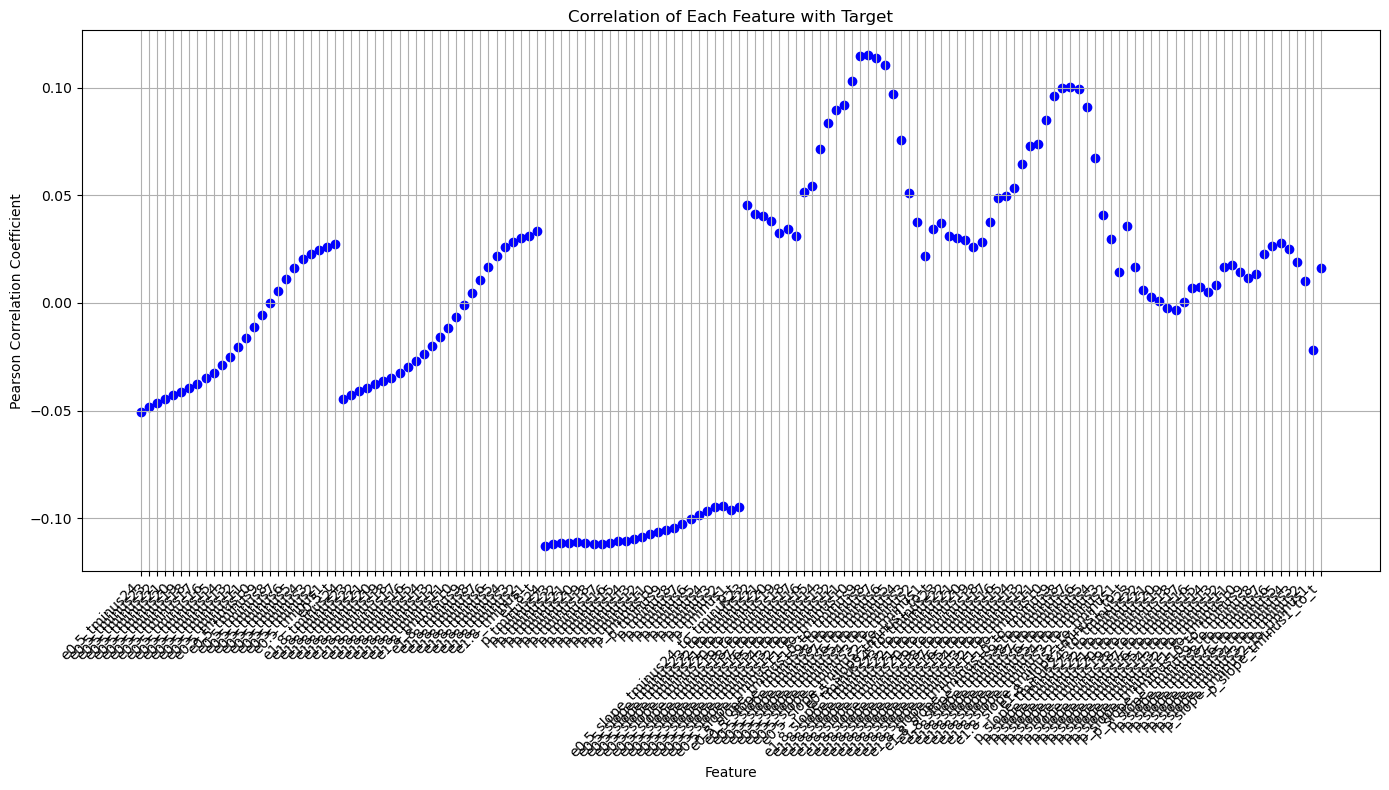

In [5]:
# Assuming X_train is shaped (24217, 75, 1) and y_train is (24217,)
# Reshape X_train to (24217, 75) for easier processing
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1])

# Initialize a list to hold correlation coefficients
correlations = []

# Calculate the Pearson correlation coefficient for each feature
for i in range(X_train_reshaped.shape[1]):
    corr, _ = pearsonr(X_train_reshaped[:, i], y_train)
    correlations.append(corr)
    
feature_names = generate_feature_names(inputs_to_use, add_slope)

# Plotting as a scatter plot
plt.figure(figsize=(14, 8))  # Adjusted figure size for better legibility
plt.scatter(range(len(correlations)), correlations, color='b')  # Use scatter instead of plot

# Adding feature names on the x-axis
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")  # Rotate labels to prevent overlap

plt.title('Correlation of Each Feature with Target')
plt.xlabel('Feature')
plt.ylabel('Pearson Correlation Coefficient')
plt.grid(True)

# Tight layout often solves cutting off issues
plt.tight_layout()
plt.show()

In [6]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
add_slope = True
target_change = False
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_dataset(root_dir + '/training',
                                 inputs_to_use=inputs_to_use,
                                 add_slope=add_slope,
                                 target_change=target_change)
X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining',
                                       inputs_to_use=inputs_to_use,
                                       add_slope=add_slope,
                                       target_change=target_change)
X_test, y_test = build_dataset(root_dir + '/testing',
                               inputs_to_use=inputs_to_use,
                               add_slope=add_slope,
                               target_change=target_change)
X_val, y_val = build_dataset(root_dir + '/validation',
                             inputs_to_use=inputs_to_use,
                             add_slope=add_slope,
                             target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
# print(f'X_train[0]: {X_train[0]}')
# print(f'y_train[0]: {y_train[0]}')

(24217, 147, 1)
(24217,)
(18952, 147, 1)
(18952,)
(10357, 147, 1)
(10357,)
(5265, 147, 1)
(5265,)
X_train.shape: (24217, 147, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 147, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 147, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 147, 1)
y_val.shape: (5265,)


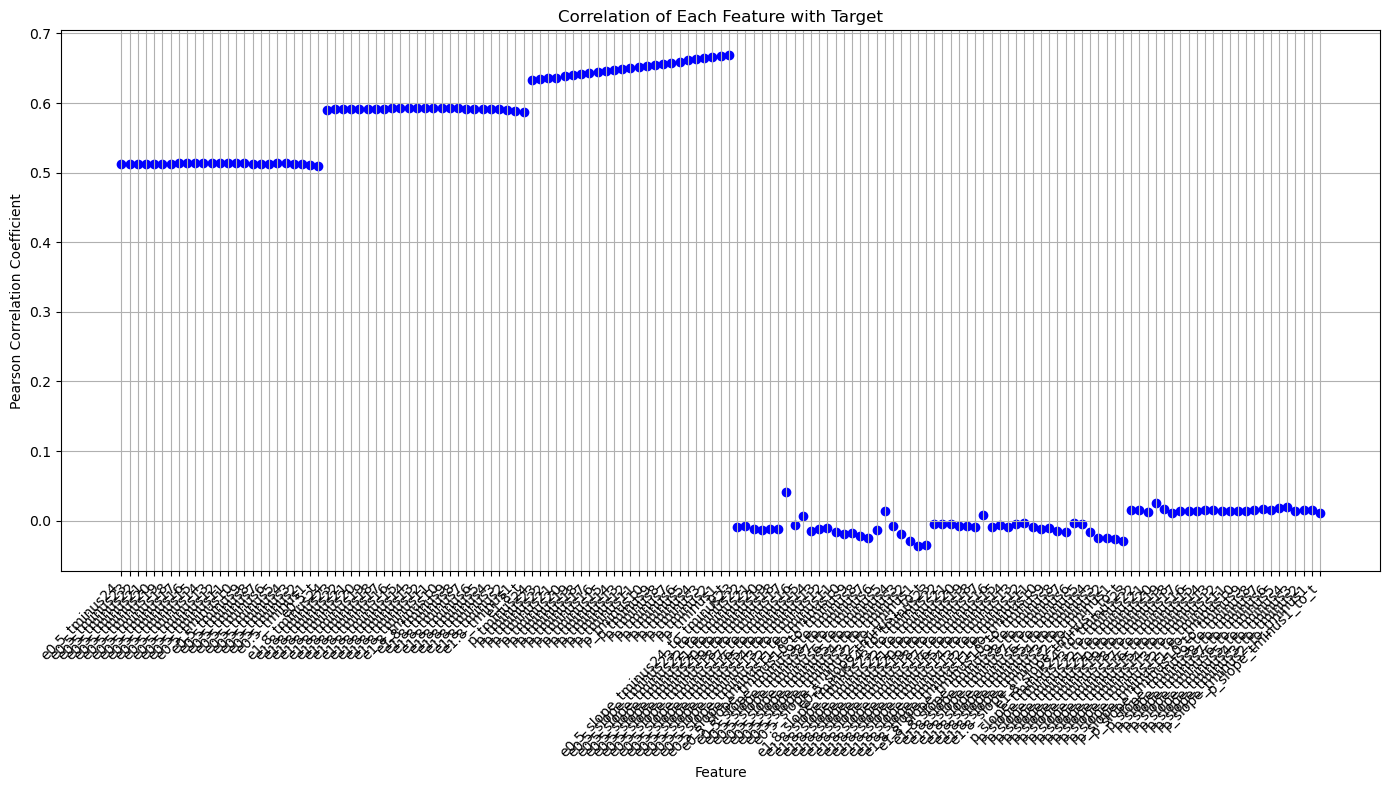

In [7]:
# Assuming X_train is shaped (24217, 75, 1) and y_train is (24217,)
# Reshape X_train to (24217, 75) for easier processing
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1])

# Initialize a list to hold correlation coefficients
correlations = []

# Calculate the Pearson correlation coefficient for each feature
for i in range(X_train_reshaped.shape[1]):
    corr, _ = pearsonr(X_train_reshaped[:, i], y_train)
    correlations.append(corr)
    
feature_names = generate_feature_names(inputs_to_use, add_slope)

# Plotting as a scatter plot
plt.figure(figsize=(14, 8))  # Adjusted figure size for better legibility
plt.scatter(range(len(correlations)), correlations, color='b')  # Use scatter instead of plot

# Adding feature names on the x-axis
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")  # Rotate labels to prevent overlap

plt.title('Correlation of Each Feature with Target')
plt.xlabel('Feature')
plt.ylabel('Pearson Correlation Coefficient')
plt.grid(True)

# Tight layout often solves cutting off issues
plt.tight_layout()
plt.show()

In [1]:
import numpy as np
from typing import List, Tuple
import time
from modules.training.cme_modeling import ModelBuilder

mb = ModelBuilder()

In [2]:
# Dummy data
batch_indices = np.random.randint(0, 100, size=1600)
joint_weights = np.random.rand(1000)
joint_weight_indices = [(np.random.randint(0, 100), np.random.randint(0, 100)) for _ in range(1000)]

In [3]:

# Measure performance and output results of the original method
start_time = time.time()
original_weights = mb.process_batch_weights(batch_indices, joint_weights, joint_weight_indices)
original_time = time.time() - start_time

# Measure performance and output results of the vectorized method
start_time = time.time()
vectorized_weights = mb.process_batch_weights_vec(batch_indices, joint_weights, joint_weight_indices)
vectorized_time = time.time() - start_time

print(f'Original method time: {original_time:.5f} seconds')
print(f'Vectorized method time: {vectorized_time:.5f} seconds')


# Check if the results are the same
print(f'shape of original_weights: {original_weights.shape}')
print(f'shape of vectorized_weights: {vectorized_weights.shape}')


print(f'original_weights: {original_weights}')
print(f'vectorized_weights: {vectorized_weights}')




Original method time: 0.38750 seconds
Vectorized method time: 0.00100 seconds
shape of original_weights: (126286,)
shape of vectorized_weights: (492,)
original_weights: [0.67008602 0.67008602 0.06705202 ... 0.42011054 0.35912132 0.32757802]
vectorized_weights: [9.12847985e-01 3.44052998e-01 6.95967629e-01 2.66842921e-01
 5.61264522e-01 9.26643954e-01 5.15300213e-01 5.27448906e-01
 7.76800360e-01 8.49708460e-01 2.84261738e-01 1.72790181e-01
 9.55832282e-01 8.59140142e-01 7.77467671e-01 9.36748462e-01
 9.94902565e-01 8.66238929e-01 4.50934403e-03 5.86108402e-01
 2.74149756e-01 1.87665390e-01 6.55073599e-01 4.19160832e-01
 4.50337823e-01 3.12658694e-01 4.98840338e-02 6.04844464e-01
 3.81884895e-01 4.01873554e-01 4.49124915e-01 6.64267011e-01
 7.35532184e-01 5.43667940e-01 9.54374580e-01 1.20549826e-01
 9.36104382e-01 7.16110647e-01 6.29211612e-01 1.70907967e-01
 1.58749210e-01 1.51403491e-01 5.96232978e-01 4.60990688e-01
 8.89440269e-01 1.56823230e-01 6.04282485e-01 3.08999765e-01
 1.6108